# Loan Eligibility Prediction

This project predicts loan approval decisions using machine learning models trained on applicant financial and demographic data. The goal is to automate and improve the accuracy of loan eligibility assessments for financial institutions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('df1_loan.csv')

In [3]:
df.head()

,Unnamed: 0,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,$5849.0
1,1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,$6091.0
2,2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,$3000.0
3,3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,$4941.0
4,4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,$6000.0


In [4]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         500 non-null    int64  
 1   Loan_ID            500 non-null    object 
 2   Gender             491 non-null    object 
 3   Married            497 non-null    object 
 4   Dependents         488 non-null    object 
 5   Education          500 non-null    object 
 6   Self_Employed      473 non-null    object 
 7   ApplicantIncome    500 non-null    int64  
 8   CoapplicantIncome  500 non-null    float64
 9   LoanAmount         482 non-null    float64
 10  Loan_Amount_Term   486 non-null    float64
 11  Credit_History     459 non-null    float64
 12  Property_Area      500 non-null    object 
 13  Loan_Status        500 non-null    object 
 14  Total_Income       500 non-null    object 
dtypes: float64(4), int64(2), object(9)
memory usage: 58.7+ KB
None
       Unna

## Clean the Data

In [5]:
# Drop index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean and convert Total_Income from $ string to float
df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)

# Encoding
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_6468\2322273334.py:14: SyntaxWarning: invalid escape sequence '\$'
  df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_6468\2322273334.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_6468\2322273334.py:9: Futu

In [6]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
0,LP001002,1,0,0,Graduate,0,5849,0.0,126.5,360.0,1.0,Urban,1,5849.0
1,LP001003,1,1,1,Graduate,0,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0
2,LP001005,1,1,0,Graduate,1,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0
3,LP001006,1,1,0,Not Graduate,0,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0
4,LP001008,1,0,0,Graduate,0,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0


## Exploratory Data Analysis

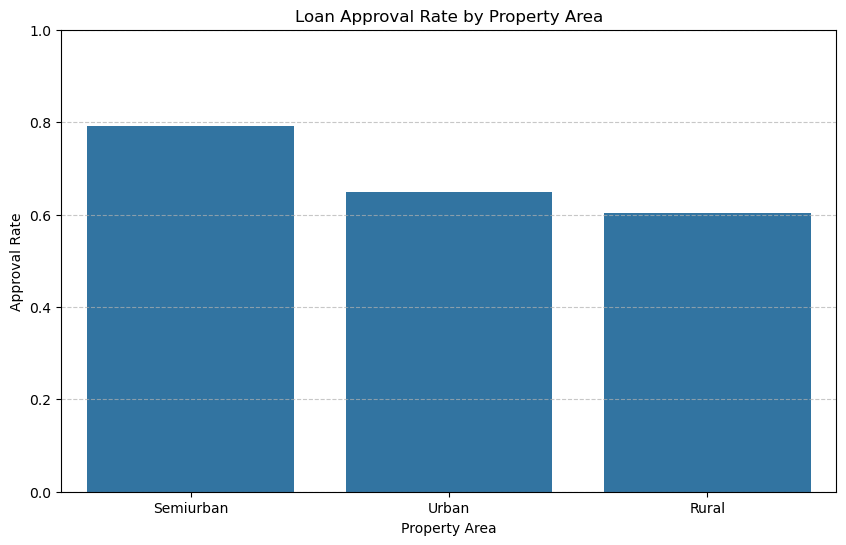

In [7]:
# Exploratory Analysis - Approval rates by Property_Area
approval_by_area = df.groupby('Property_Area')['Loan_Status'].mean().reset_index()
approval_by_area.columns = ['Property_Area', 'Approval_Rate']

# Sort areas by approval rate for better visualization
approval_by_area = approval_by_area.sort_values('Approval_Rate', ascending=False)

# Statistical testing - Chi-square test for independence
contingency_table = pd.crosstab(df['Property_Area'], df['Loan_Status'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Property_Area', y='Approval_Rate', data=approval_by_area)
plt.title('Loan Approval Rate by Property Area')
plt.ylabel('Approval Rate')
plt.xlabel('Property Area')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Observation
- Rural loan approvals by Property Area is the lowest.
- Semiurban is has the highest approval rate.

## Data Preprocessing

This includes:
- One-hot encoding for categorical variables (Education, Property_Area)
- Feature engineering: income per dependent, EMI calculation, and balance income
- Log transformation of skewed numerical features

In [8]:
# One-hot encode the remaining categorical features
categorical_features = ['Education', 'Property_Area']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Feature engineering
df['Income_per_dependent'] = df['Total_Income'] / (df['Dependents'] + 1)
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']
df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)

# Log transform skewed numerical features
df['LoanAmount_Log'] = np.log(df['LoanAmount'])
df['Total_Income_Log'] = np.log(df['Total_Income'])

## Model Building and Model Evaluation

- Logistic Regression: With standardized features for better performance
- Random Forest: Without standardization (tree-based models don't require it)

In [9]:
# Split features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Drop unnecessary columns for modeling
X = X.drop(['Loan_ID'], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    # Feature importance for Random Forest
    if isinstance(model, RandomForestClassifier):
        importances = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importances.head(10))
        plt.title('Top 10 Feature Importances')
        plt.tight_layout()
        plt.show()
    
    return model, accuracy

Logistic Regression Model:
Accuracy: 0.8200

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.52      0.64        31
           1       0.81      0.96      0.88        69

    accuracy                           0.82       100
   macro avg       0.83      0.74      0.76       100
weighted avg       0.82      0.82      0.81       100


Confusion Matrix:
[[16 15]
 [ 3 66]]

CV Accuracy for Logistic Regression: 0.8025 ± 0.0255

Random Forest Model:
Accuracy: 0.8300

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69        31
           1       0.84      0.93      0.88        69

    accuracy                           0.83       100
   macro avg       0.82      0.77      0.79       100
weighted avg       0.83      0.83      0.82       100


Confusion Matrix:
[[19 12]
 [ 5 64]]


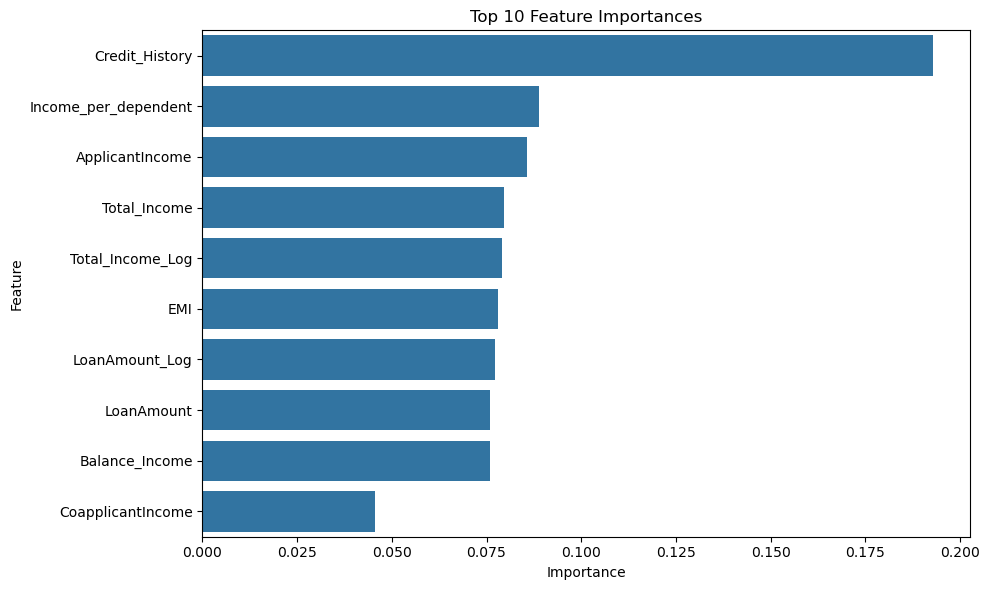


CV Accuracy for Random Forest: 0.7850 ± 0.0339


In [11]:
# Logistic Regression
print("Logistic Regression Model:")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model, lr_accuracy = evaluate_model(lr_model, X_train_scaled, X_test_scaled, y_train, y_test)

# Cross-validation for Logistic Regression
cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)
print(f"\nCV Accuracy for Logistic Regression: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Random Forest Classifier
print("\nRandom Forest Model:")
rf_model = RandomForestClassifier(random_state=42)
rf_model, rf_accuracy = evaluate_model(rf_model, X_train, X_test, y_train, y_test)

# Cross-validation for Random Forest
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"\nCV Accuracy for Random Forest: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

### Key Findings
- Logistic Regression model correctly predicts loan eligibility for 82% of cases in the test set.
- Random Forest model performed slightly better than Logistic Regression (83% vs. 82%).

If minimizing false approvals (e.g., reducing bank risk) is critical, Random Forest is better. If avoiding false rejections (e.g., customer satisfaction) matters more, Logistic Regression may be preferred.

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.8025
Accuracy: 0.8400

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.55      0.68        31
           1       0.83      0.97      0.89        69

    accuracy                           0.84       100
   macro avg       0.86      0.76      0.79       100
weighted avg       0.85      0.84      0.83       100


Confusion Matrix:
[[17 14]
 [ 2 67]]


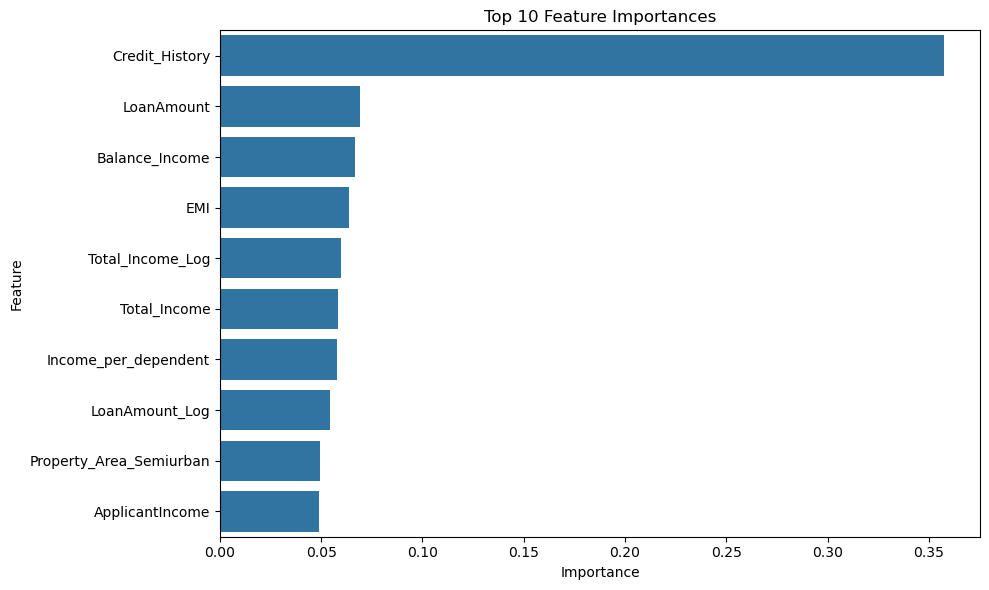

In [12]:
# Hyperparameter tuning for Random Forest (commented out to save runtime)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='accuracy',
                           verbose=1)

grid_search.fit(X_train, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

best_rf_model = grid_search.best_estimator_
best_rf_model, best_rf_accuracy = evaluate_model(best_rf_model, X_train, X_test, y_train, y_test)

### Key Insights

- High Precision for Class 0 (89%): Useful if the priority is minimizing risky loans (fewer false approvals).
- Low Recall for Class 0 (55%): The model misses 45% of truly ineligible applicants, exposing the bank to potential defaults.
- Class 1 Dominance: The model is biased toward approving loans (97% recall for Class 1), likely due to class imbalance (69 Class 1 vs. 31 Class 0 samples).

In [20]:
# Function to make predictions for new data
def predict_loan_eligibility(model, new_data, is_rf=False):
    # Preprocess new data similarly to training data
    if not is_rf:
        new_data_scaled = scaler.transform(new_data)
        prediction = model.predict(new_data_scaled)
    else:
        prediction = model.predict(new_data)
    
    return "Eligible for loan" if prediction[0] == 1 else "Not eligible for loan"

# Example: Sample data for prediction

sample = pd.DataFrame({
    'Gender': [1],                           # Male
    'Married': [1],                          # Yes
    'Dependents': [2],                       # 2
    'Self_Employed': [0],                    # No
    'ApplicantIncome': [5000],
    'CoapplicantIncome': [1500],
    'LoanAmount': [120],
    'Loan_Amount_Term': [360],
    'Credit_History': [1],                   # Has credit history
    'Total_Income': [6500],
    'Education_Not Graduate': [0],           # Changed from Graduate=1 to Not Graduate=0
    'Property_Area_Semiurban': [1],          # Semiurban area
    'Property_Area_Urban': [0],              # Not urban area
    'Income_per_dependent': [2166.67],       # Calculated
    'EMI': [0.33],                           # Calculated
    'Balance_Income': [6170],                # Calculated
    'LoanAmount_Log': [4.79],                # Log transformed
    'Total_Income_Log': [8.78]               # Log transformed
})

# Make predictions
lr_prediction = predict_loan_eligibility(lr_model, sample, is_rf=False)
rf_prediction = predict_loan_eligibility(rf_model, sample, is_rf=True)

print(f"\nLogistic Regression Prediction: {lr_prediction}")
print(f"Random Forest Prediction: {rf_prediction}")



Logistic Regression Prediction: Eligible for loan
Random Forest Prediction: Eligible for loan


### Key Insights

The Sample Applican Profile is a male, married applicant with 2 dependents and lives in the semiurban area. 

#### Why Both Models Might Agree (or Disagree)

Agreement (Both "Eligible"):
- Strong common factors (credit history, income) dominate.

Disagreement:
- Logistic Regression might be more sensitive to outliers or skewed features (e.g., LoanAmount_Log).
- Random Forest could capture complex interactions (e.g., Property_Area_Semiurban + Education).

#### Actionable Insights

If Predictions Differ:

1. Check feature importances (use rf_model.feature_importances_) to see which features each model prioritized.
2. For Logistic Regression, examine coefficients (e.g., lr_model.coef_) for linear impacts.

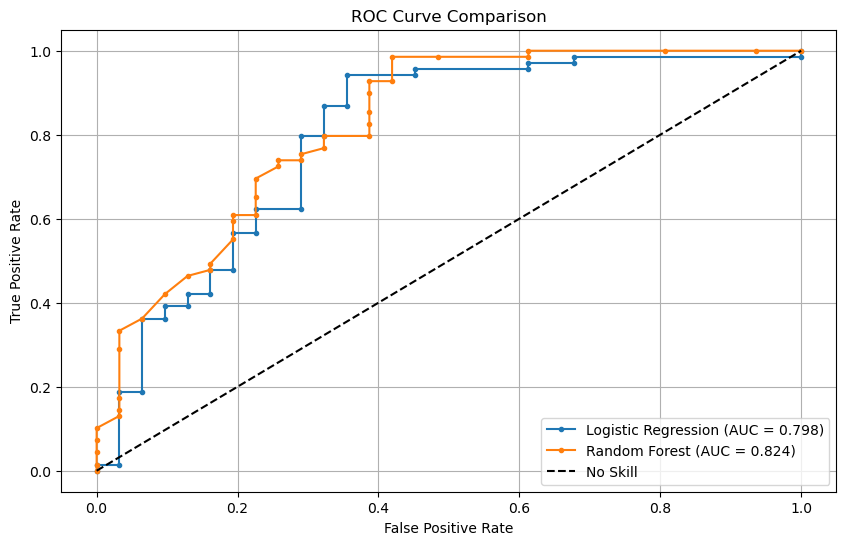

In [18]:
# ROC Curve Comparison
from sklearn.metrics import roc_curve, roc_auc_score

# Get predictions for ROC
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# Calculate ROC Curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(rf_fpr, rf_tpr, marker='.', label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Compare model performance
print("\nModel Performance Comparison:")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

if lr_accuracy > rf_accuracy:
    print("\nLogistic Regression performed better on the test set.")
else:
    print("\nRandom Forest performed better on the test set.")


Model Performance Comparison:
Logistic Regression Accuracy: 0.8200
Random Forest Accuracy: 0.8300

Random Forest performed better on the test set.


## Conclusion

The tuned Random Forest (84% accuracy) strikes the best balance for this use case, but further refinement (e.g., threshold adjustment) could optimize risk vs. customer experience.

### Model Performance

- Logistic Regression: Achieved 82% accuracy with strong precision for rejected loans (84%) but lower recall (52%), indicating it often misses ineligible applicants.
- Random Forest: Slightly better accuracy (83%) and improved recall for rejections (61%), though still missed 39% of risky applicants. After hyperparameter tuning, accuracy reached 84%, with higher precision (89%) for rejections.

### Business Implications

For Lenders:

- The tuned Random Forest is preferable if minimizing false approvals (risky loans) is critical (89% precision for rejections).
- Logistic Regression may suffice if prioritizing customer satisfaction (fewer false rejections).

For Applicants:
- Approval heavily depends on credit history, income stability, and low debt-to-income ratios (EMI).

### Limitations & Improvements

- Class Imbalance: The dataset had more approved loans (69%) than rejections (31%), biasing models toward approvals. Solutions: Use class_weight='balanced' or oversample the minority class.
- Feature Engineering: Derived features (e.g., Income_per_dependent) helped, but deeper analysis of interactions (e.g., Credit_History × Property_Area) could improve recall.
- Model Exploration: Testing XGBoost or SHAP values could provide better interpretability and performance.